In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import qgrid
from WindPy import w
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [976]:
ldf = pd.read_excel('D:/workspace/crusader/data/list.xlsx')
ldf = ldf.dropna().set_index(u'代码')
# ldf = ldf.drop_duplicates()

In [136]:
ldf.head()

,名称
代码,
M0000612,消费者物价指数（CPI）
M0000616,CPI-食品
M0000617,CPI-粮食
M0044542,CPI-猪肉
M0000622,CPI-鲜菜


In [3]:
DATA_DIR = 'D:/Data/industry/'

In [4]:
industry = [x for x in os.listdir(DATA_DIR)]

In [5]:
df = ''
for ind in industry:
    files = [f for f in os.listdir('%s/%s'%(DATA_DIR, ind))]
    for f in files:
        fname = '%s/%s/%s'%(DATA_DIR, ind, f)
        if not isinstance(df, pd.DataFrame):
            df = pd.read_excel(fname)
        else:
            tdf = pd.read_excel(fname)
            cols = tdf.columns.difference(df.columns)
            df = df.merge(tdf[cols], how='outer', left_index=True, right_index=True)

# 取月度数据

In [6]:
df = df.fillna(method='ffill').resample('BM').last()

# 删掉历史数据过少的数据

In [870]:
df.columns

Index([u'M0000617', u'M0000616', u'M0000622', u'M5462042', u'S0109326',
       u'M0000612', u'S0109328', u'S0031749', u'S0037083', u'S0039170',
       ...
       u'S0030518', u'S0000066', u'M0067855', u'S0030509', u'S0030512',
       u'M0000545', u'S0035972', u'S0030503', u'S0030527', u'S0030515'],
      dtype='object', length=114)

In [871]:
df = df[df.index >= '2004-01-01']

In [872]:
df = df.dropna(axis=1)

# 特征选择

In [873]:
df.shape

(170, 114)

In [11]:
data = w.wsd('881001.WI', 'close', '2003-12-01', '2018-02-28')

In [12]:
sdf = pd.DataFrame(np.array(data.Data).T, index=pd.to_datetime(data.Times), columns=data.Codes)

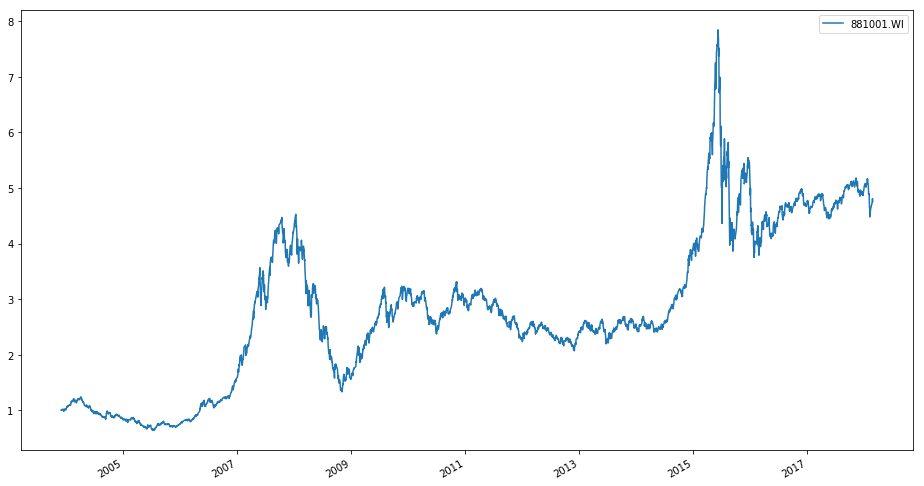

In [879]:
(1+sdf.pct_change()).cumprod().plot(figsize=(16, 9))

In [968]:
k = 6
X = df.copy()
y = sdf['881001.WI'].resample('BM').last().pct_change(k)

In [969]:
pred_x = X.iloc[-k:]
X = X.iloc[:-k]
y = y.shift(-k).iloc[1:-k]

In [970]:
X.shape, y.shape

((164, 114), (164L,))

In [971]:
lasso = linear_model.Lasso()

In [972]:
lasso.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [973]:
X.columns[lasso.coef_ != 0]

Index([u'S0109328', u'M5567879', u'M0002003', u'M0001495', u'M0009973',
       u'M0001493', u'M0011790', u'S0031550', u'S6100196', u'M0041571',
       u'S0027282', u'S0028288', u'S5103551', u'S5103365', u'S5103573',
       u'S5103411', u'S0027009', u'S5808574', u'S0029764', u'S5808575',
       u'S0029752', u'S5808576', u'S0029756', u'S5808573', u'S0029760',
       u'S0049493', u'S0049494', u'S0033155', u'S0046390', u'S0027495'],
      dtype='object')

In [977]:
ldf.loc[X.columns[lasso.coef_ != 0].tolist(), :]

,名称
代码,
S0109328,秋粮产量
M5567879,名义GDP
M0002003,商业银行不良贷款余额
M0001495,定期存款同比增速
M0009973,月度新增人民币贷款
M0001493,活期存款同比增速
M0011790,银行业金融机构税后利润
S0031550,BDI
S0031550,BDI


# 训练

In [978]:
tX = X[X.columns[lasso.coef_ != 0]]

In [979]:
lr = linear_model.LinearRegression()

In [980]:
lr.fit(tX, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [981]:
lr.coef_

array([  1.03814244e-04,   1.10788725e-05,  -1.60992750e-05,
         6.47338904e-07,  -9.88072422e-06,   1.10352058e-06,
        -1.22308322e-04,  -5.70118574e-05,  -5.48586163e-08,
         8.08862444e-06,   2.84085303e-04,   6.61103671e-04,
         2.03419245e-09,   1.47039622e-08,   8.86018754e-09,
        -2.30530283e-08,  -1.60816885e-06,  -3.29140509e-04,
        -1.79476455e-06,  -1.41218537e-04,  -4.14326979e-07,
         3.12193549e-04,   1.15905622e-07,   3.99844533e-04,
         3.11046954e-08,  -1.44275211e-07,  -3.65054140e-07,
        -2.00063472e-04,   2.01746320e-04,   1.17494349e-03])

In [982]:
lr.score(tX, y)

0.83315380800026517

In [983]:
scores = cross_val_score(lr, X, y, cv=10)

In [984]:
scores.mean()

-774.37794476644285

In [985]:
pred_y = lr.predict(tX)
future_y = lr.predict(pred_x[pred_x.columns[lasso.coef_ != 0]])

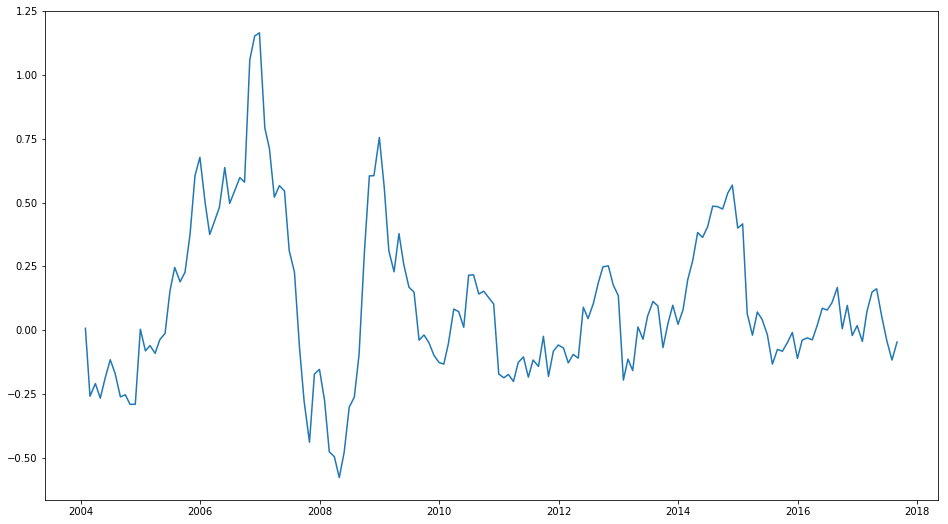

In [986]:
# pd.Series(pred_y, index=y.index).plot(figsize=(16, 9), label='predict')
plt.figure(figsize=(16, 9))
plt.plot(pd.Series(pred_y, index=y.index))
# plt.plot((1 + sdf['881001.WI'].pct_change()).cumprod() - 1)
# y.plot(figsize=(16, 9), label='true')
# pd.Series(future_y, index=pred_x.index).plot(figsize=(16, 9), label='future', color='red')
plt.legend()

In [987]:
lr = linear_model.LinearRegression()
lr.fit(pred_y.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

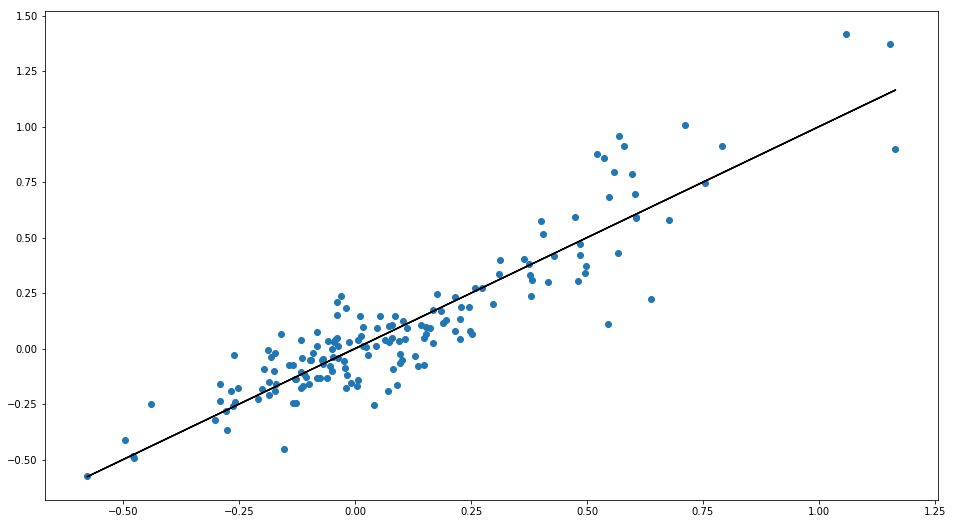

In [988]:
plt.figure(figsize=(16, 9))
plt.scatter(pred_y, y)
plt.plot(pred_y, lr.predict(pred_y.reshape(-1, 1)), color='black')

In [895]:
future_y

array([ 0.02403762])

In [896]:
X_train, X_test, y_train, y_test = train_test_split(tX, y, test_size=0.4, random_state=0)

In [897]:
lr = linear_model.ElasticNet()
lr.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [898]:
lr.score(X_train, y_train)

0.40557505019092138

In [899]:
lr.score(X_test, y_test)

-0.2411410326582244

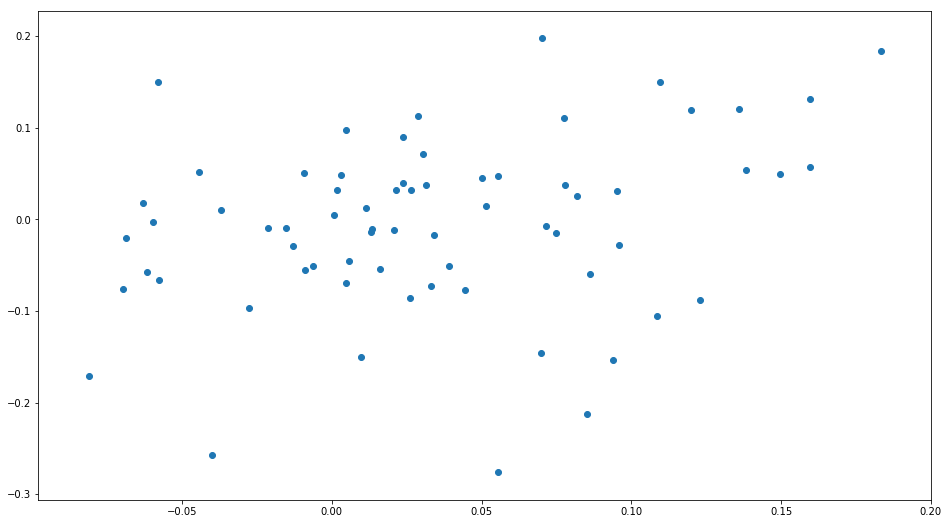

In [901]:
plt.figure(figsize=(16, 9))
plt.scatter(lr.predict(X_train), y_train)
plt.scatter(lr.predict(X_test), y_test)

# 滚动训练

In [808]:
k = 3
X = df.copy()
y = sdf['881001.WI'].resample('BM').last().pct_change(k)

In [809]:
pred_x = X.iloc[-k:]
X = X.iloc[:-k]
# y = y.iloc[1: ]
y = y.shift(-k).iloc[1:-k]

In [810]:
X.shape, y.shape

((167, 114), (167L,))

In [819]:
pred_y = pd.Series(index=y.index)
tX = X[X.columns[lasso.coef_ != 0]]
sample = 60
for date in X.index:
    train_x, train_y = X[X.index < date][-sample:-k], y[y.index < date][-sample:-k]
    if train_x.shape[0] == sample - k:
        lasso = linear_model.Lasso()
        lasso.fit(train_x, train_y)
        pred_y.loc[date] = lasso.predict([X.loc[date].values.squeeze()])[0]
#         lr = linear_model.LinearRegression()
#         lr.fit(train_x[train_x, train_y)
#         pred_y.loc[date] = lr.predict([X.loc[date].values.squeeze()])[0]

In [820]:
# lr.predict([X.loc[date].values.squeeze()])

In [821]:
pred_y.shape, y.shape

((167L,), (167L,))

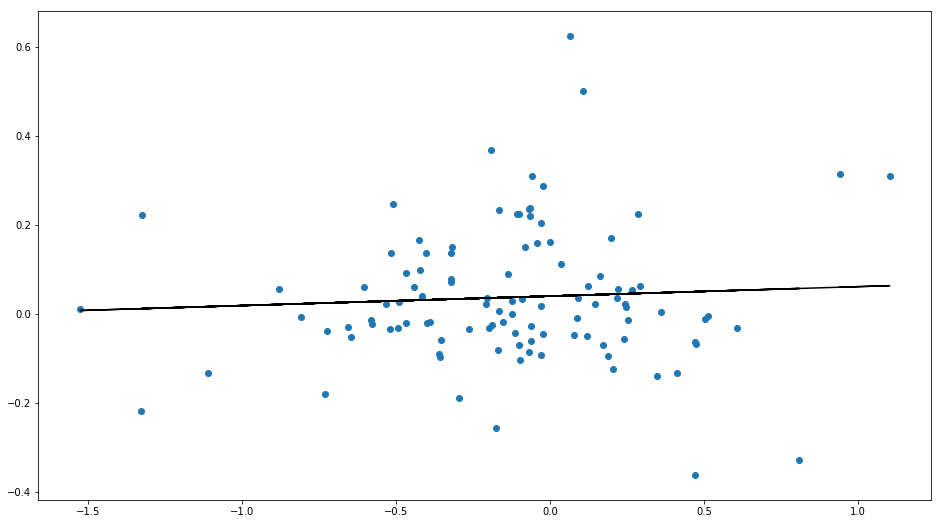

In [822]:
fit_lr = linear_model.LinearRegression()
fit_lr.fit(pred_y.dropna().values.reshape(-1, 1), y.loc[pred_y.dropna().index])
plt.figure(figsize=(16, 9))
plt.scatter(pred_y.dropna(), y.loc[pred_y.dropna().index])
plt.plot(pred_y.dropna(), fit_lr.predict(pred_y.dropna().values.reshape(-1, 1)), color='black')

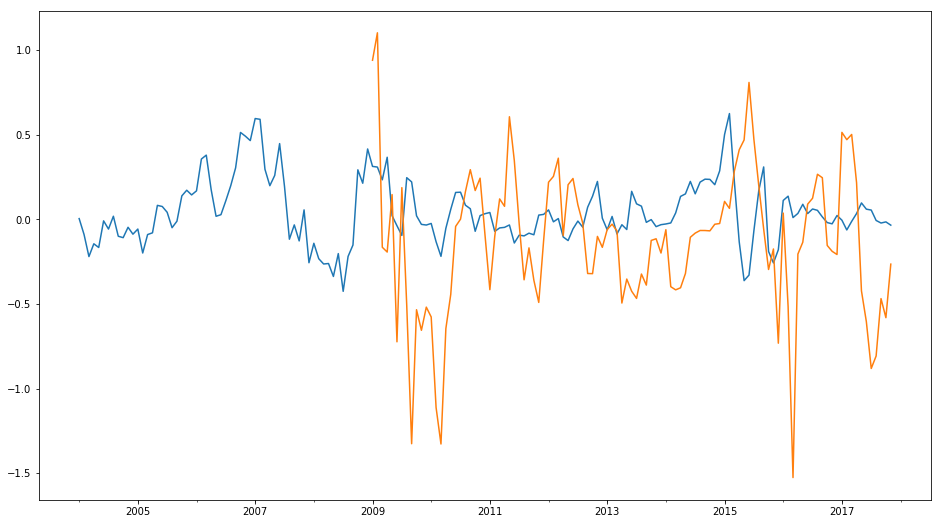

In [823]:
plt.figure(figsize=(16, 9))
y.plot(label='true')
pred_y.plot(label='predict')

In [807]:
lasso.predict(pred_x)

array([ 0.06972275])

# 分类问题（当月）

In [907]:
X = df.copy()
tX = X[X.columns[lasso.coef_ != 0]]
y = sdf['881001.WI'].resample('BM').last().pct_change().iloc[1:]

In [908]:
label = y.copy()
label[label > 0] = 1
label[label < 0] = 0

In [912]:
lr = linear_model.LogisticRegression(C=1)
lr.fit(tX, label)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [914]:
scores = cross_val_score(lr, X, label, cv=10)

In [916]:
scores.mean()

0.48819444444444449

In [917]:
rf = ensemble.RandomForestClassifier()
rf.fit(tX, label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [918]:
scores = cross_val_score(rf, X, label, cv=10)

In [919]:
scores.mean()

0.45224673202614374

# 分类问题（趋势：未来k个月收益率）

In [920]:
k = 6
tX = X[X.columns[lasso.coef_ != 0]]
y = sdf['881001.WI'].resample('BM').last().pct_change(periods=k).iloc[1:]

In [921]:
y = y.shift(-(k-1))

In [922]:
predX = tX.iloc[-(k-1):]
tX = tX.iloc[:-(k-1)]
y = y.iloc[:-(k-1)]

In [923]:
label = y.copy()
label[label > 0] = 1
label[label < 0] = 0

In [924]:
tX.shape, label.shape

((165, 24), (165L,))

In [926]:
lr = linear_model.LogisticRegression(C=0.6)
lr.fit(tX, label)

LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [927]:
scores = cross_val_score(lr, tX, label, cv=20)

In [928]:
scores.mean()

0.71507936507936498

In [929]:
lr.predict(predX)

array([ 0.,  0.,  0.,  0.,  0.])

# 分类问题（这个月与之后k个月取xor）

In [933]:
tX = X[X.columns[lasso.coef_ != 0]]
y = sdf['881001.WI'].resample('BM').last().pct_change().iloc[1:]

In [934]:
label = y.copy()
label[label > 0] = 1
label[label < 0] = 0

In [935]:
k = 3
y2 = sdf['881001.WI'].resample('BM').last().pct_change(periods=k).iloc[1:]

In [936]:
label2 = y2.copy()
label2[label2 > 0] = 1
label2[label2 < 0] = 0

In [937]:
label = label + label2.shift(-k)
label[label == 2] = 0

In [938]:
pred_x = tX.iloc[-k:]
tX = tX.iloc[:-k]
label = label.iloc[:-k]

In [945]:
lr = linear_model.LogisticRegression(C=0.01)
lr.fit(tX, label)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [946]:
scores = cross_val_score(lr, tX, label, cv=20)

In [947]:
scores.mean()

0.41567460317460314